In [141]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [142]:
# itermethod = "JACOBI"
# itermethod = "GAUSSSEIDEL"
# itermethod = "SOR"
# itermethod = "RBGS"

dim = 3;

# arch = "CPU"
# arch = "GPU"

# itermethod_list = ["JACOBI", "RBGS"]
# itermethod_list = ["JACOBI", "GAUSSSEIDEL", "SOR", "Multigrid_1", "Multigrid_4"]
# itermethod_list = ["Multigrid_1", "Multigrid_2", "Multigrid_3", "Multigrid_4"]
# itermethod_list = ["Multigrid_1", "Multigrid_2", "Multigrid_3"]
# itermethod_list = ["Multigrid_1", "Multigrid_2"]
# itermethod_list = ["Multigrid_2", "Multigrid_3"]
# itermethod_list = ["Multigrid_2"]
itermethod_list = ["Multigrid_2"]
# arch_list = ["CPU"]
# arch_list = ["GPU"]
arch_list = ["CPU", "GPU"]

data_list = []

In [143]:
for itermethod in itermethod_list:
    for arch in arch_list:
        filename = "../output/{0}_{1}D_{2}.bin".format(itermethod, dim, arch)
        print(filename)
        fileinfo = "../output/{0}_{1}D_dim_type_{2}.txt".format(itermethod, dim, arch)
        print(fileinfo)
        filedelta = "../output/{0}_{1}D_delta_{2}.bin".format(itermethod, dim, arch)
        print(filedelta)

        with open(fileinfo, "r") as info:
            lines = info.readlines()
            for row in lines:
                line_data = row.strip("\n")
                line_data = line_data.split(" ")
                Mdim = int(line_data[1])
                Ndim = int(line_data[2])
                Kdim = int(line_data[3])
                sizeof = int(line_data[5])

        if sizeof == 4:
            type_t = np.float32
        else:
            type_t = np.float64

        x_vector = np.linspace(0, 1, Kdim)
        y_vector = np.linspace(0, 1, Ndim)
        X, Y = np.meshgrid(x_vector, y_vector)
        
        data = np.zeros([Mdim, Ndim, Kdim], dtype=type_t)
        with open(filename, "rb") as f:
            data = np.fromfile(f, dtype=type_t, count=-1).reshape([Mdim, Ndim, Kdim])
            data_list.append(data)

        with open(filedelta, "rb") as fndelta:
            delta = np.fromfile(fndelta, dtype=np.float64, count=-1)

        fig = plt.figure(figsize=(21, 6))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132, projection='3d')
        ax3 = fig.add_subplot(133)
        # fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle("method: {0} dim: {1} arch: {2}".format(itermethod, dim, arch))

        if dim == 1:
            ax1.plot(x_vector, data[-1, -1, :])
            ax1.grid()

            ax2.plot3D(x_vector, np.zeros_like(x_vector), data[-1, -1, :])

            ax3.plot(delta)
            ax3.grid()
        elif dim == 2:
            im = ax1.imshow(data[-1, :, :], cmap=plt.cm.jet, extent=[0, 1, 0, 1])
            cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.8)

            surf = ax2.plot_surface(X, Y, data[-1, :, :], cmap=plt.cm.jet)
            # ax2.figure.colorbar(surf, ax=ax2, shrink=0.8)

            ax3.plot(np.arange(0, len(delta), 1), delta)
            # ax3.scatter(np.arange(0, len(delta), 1), delta)
            ax3.grid()
        elif dim == 3:
            im = ax1.imshow(data[Mdim//2, :, :], cmap=plt.cm.jet, extent=[0, 1, 0, 1])
            cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.8)

            surf = ax2.plot_surface(X, Y, data[Mdim//2, :, :], cmap=plt.cm.jet)
            # ax2.figure.colorbar(surf, ax=ax2, shrink=0.8)
            # ax2.figure.colorbar(surf, ax=ax2, shrink=0.8, pad=0.08)

            ax3.plot(np.arange(0, len(delta), 1), delta)
            ax3.grid()
    

../output/Multigrid_2_3D_CPU.bin
../output/Multigrid_2_3D_dim_type_CPU.txt
../output/Multigrid_2_3D_delta_CPU.bin
../output/Multigrid_2_3D_GPU.bin
../output/Multigrid_2_3D_dim_type_GPU.txt
../output/Multigrid_2_3D_delta_GPU.bin


(400, 400, 400)
(400, 400, 400)
8.266162197245741e-05
8.266162197245741e-05


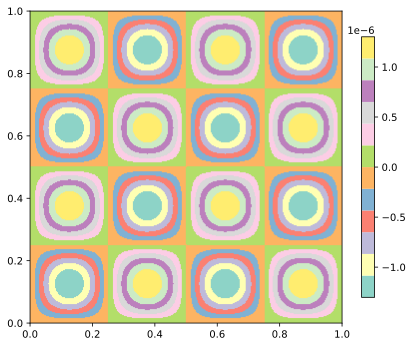

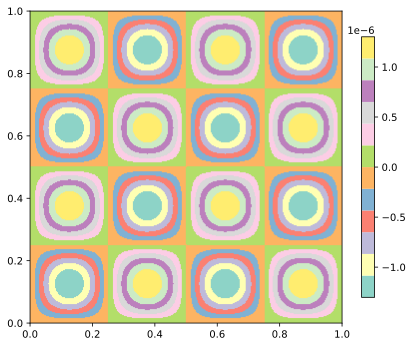

In [144]:
from numba import cuda

@cuda.jit()
def computeExact_2D(u_exact):
    k = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    j = cuda.threadIdx.y + cuda.blockDim.y * cuda.blockIdx.y

    if (k < Kdim and j < Ndim):
        u_exact[0][j][k] = math.sin(KHZ * math.pi * k * DH) * math.sin(KHZ * math.pi * j * DH)

@cuda.jit()
def computeExact_3D(u_exact):
    k = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    j = cuda.threadIdx.y + cuda.blockDim.y * cuda.blockIdx.y
    i = cuda.threadIdx.z + cuda.blockDim.z * cuda.blockIdx.z

    if (k < Kdim and j < Ndim and i < Mdim):
        u_exact[i][j][k] = math.sin(KHZ * math.pi * k * DH) * math.sin(KHZ * math.pi * j * DH) * math.sin(KHZ * math.pi * i * DH)

KHZ = 4
# KHZ = 10
# KHZ = 20

x = np.linspace(0, 1, Kdim)
y = np.linspace(0, 1, Ndim)
DH = 1 / (Kdim - 1)
u_exact = np.zeros((Mdim, Ndim, Kdim))

u_exact_dev = cuda.to_device(u_exact)
block = (32, 16, 1)
grid_x = int(math.ceil(Kdim / block[0]))
grid_y = int(math.ceil(Ndim / block[1]))
grid_z = int(math.ceil(Mdim / block[2]))
grid = (grid_x, grid_y, grid_z)

if (dim == 2):
    computeExact_2D[grid, block](u_exact_dev)
elif (dim == 3):
    computeExact_3D[grid, block](u_exact_dev)

# cuda.synchronize()
u_exact = u_exact_dev.copy_to_host()

# if (dim == 2):
#     for j in range(Ndim):
#         for i in range(Kdim):
#             u_exact[0][j][i] = math.sin(KHZ * math.pi * i * DH) * math.sin(KHZ * math.pi * j * DH)

# if (dim == 3):
#     for k in range(Mdim):
#         for j in range(Ndim):
#             for i in range(Kdim):
#                 u_exact[k][j][i] = math.sin(KHZ * math.pi * i * DH) * math.sin(KHZ * math.pi * j * DH) * math.sin(KHZ * math.pi * k * DH)

print(u_exact.shape)
print(data_list[0].shape)

for i in range(len(data_list)):
    fig = plt.figure(figsize=(7, 6))
    ax1 = fig.add_subplot(111)
    print(np.max(u_exact - data_list[0]))

    if dim == 1:
        ax1.plot(x_vector, data_list[0][-1, -1, :] - data_list[1][-1, -1, :])
        ax1.grid()

    elif dim == 2:
        # im = ax1.imshow(u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
        im = ax1.imshow(data_list[i][-1, :, :] - u_exact[0], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
        # im = ax1.imshow(data_list[0][-1, :, :] - u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
        # im = ax1.imshow(data_list[0][-1, :, :] - data_list[1][-1, :, :], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
        cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.96)

    elif dim == 3:
        im = ax1.imshow(data_list[i][Mdim//2, :, :] - u_exact[Mdim//2, :, :], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
        # im = ax1.imshow(data_list[i][Mdim//2, :, :] - u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
        # im = ax1.imshow(data_list[0][Mdim//2, :, :] - data_list[1][Mdim//2, :, :], cmap=plt.cm.jet, extent=[0, 1, 0, 1])
        cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.8)


In [145]:

# KHZ = 4
# # KHZ = 10
# # KHZ = 20

# x = np.linspace(0, 1, Kdim)
# y = np.linspace(0, 1, Ndim)
# DH = 1 / (Kdim - 1)
# u_exact = np.zeros((Mdim, Ndim, Kdim))

# if (dim == 2):
#     for j in range(Ndim):
#         for i in range(Kdim):
#             u_exact[0][j][i] = math.sin(KHZ * math.pi * i * DH) * math.sin(KHZ * math.pi * j * DH)

# if (dim == 3):
#     for k in range(Mdim):
#         for j in range(Ndim):
#             for i in range(Kdim):
#                 u_exact[k][j][i] = math.sin(KHZ * math.pi * i * DH) * math.sin(KHZ * math.pi * j * DH) * math.sin(KHZ * math.pi * k * DH)

# print(u_exact.shape)
# print(data_list[0].shape)

# for i in range(len(data_list)):
#     fig = plt.figure(figsize=(7, 6))
#     ax1 = fig.add_subplot(111)
#     print(np.max(u_exact - data_list[0]))

#     if dim == 1:
#         ax1.plot(x_vector, data_list[0][-1, -1, :] - data_list[1][-1, -1, :])
#         ax1.grid()

#     elif dim == 2:
#         # im = ax1.imshow(u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
#         im = ax1.imshow(data_list[i][-1, :, :] - u_exact[0], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
#         # im = ax1.imshow(data_list[0][-1, :, :] - u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
#         # im = ax1.imshow(data_list[0][-1, :, :] - data_list[1][-1, :, :], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
#         cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.96)

#     elif dim == 3:
#         im = ax1.imshow(data_list[i][Mdim//2, :, :] - u_exact[Mdim//2, :, :], cmap=plt.cm.Set3, extent=[0, 1, 0, 1])
#         # im = ax1.imshow(data_list[i][Mdim//2, :, :] - u_exact, cmap=plt.cm.jet, extent=[0, 1, 0, 1])
#         # im = ax1.imshow(data_list[0][Mdim//2, :, :] - data_list[1][Mdim//2, :, :], cmap=plt.cm.jet, extent=[0, 1, 0, 1])
#         cbar = ax1.figure.colorbar(im, ax=ax1, shrink=0.8)
